<a href="https://colab.research.google.com/github/aleksandrast12/PUM_projekt_PZS/blob/main/Projekt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor

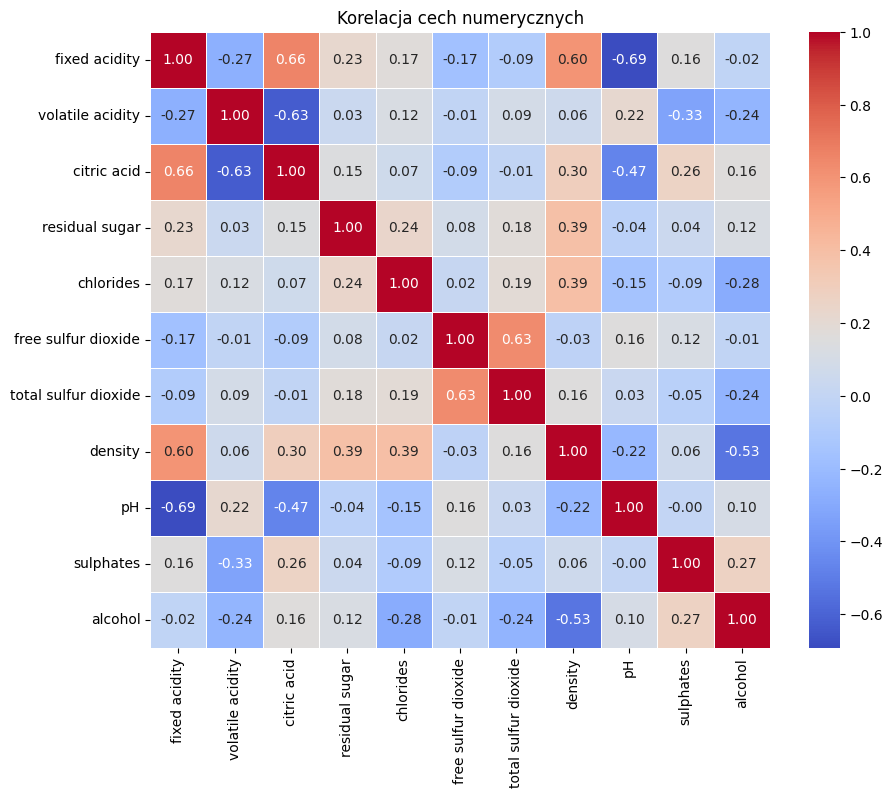

In [3]:

# y to quality

df = pd.read_csv("test.csv")

#df.drop_duplicates() - nie obowiazuje gdyz nawet przy jednym powtarzajacym sie elemencie inne cechy rozniace sie moga miec wplyw na ocene jakosci

#nie musimy usuwac kolumn
columns = ['fixed acidity',"volatile acidity","citric acid","residual sugar","chlorides","free sulfur dioxide","total sulfur dioxide","density","pH","sulphates","alcohol","quality"]
FeaturesToConvert = ['citric acid','residual sugar','chlorides']
for feature in FeaturesToConvert:
   df[feature] = df[feature].str.strip('-_')
for feature in FeaturesToConvert:
  df[feature] = df[feature].astype('float64')
for column in columns:
   df[column] = df[column].replace({'':np.nan})
#df.isna().sum()
df['density'] = df['density'].fillna(method='pad')

for column in  df[columns]:
  df[column]=np.abs(df[column])
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3- Q1
  df = df.drop(df.loc[df[column] > (Q3 + 1.5 * IQR)].index)
  df = df.drop(df.loc[df[column] < (Q1- 1.5 * IQR)].index)

scaler = preprocessing.StandardScaler().fit(df)
numerical_columns = df.select_dtypes(include=[float, int]).columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])


features = df.drop(columns=['quality'])
plt.figure(figsize=(10, 8))
sns.heatmap(features.corr(), annot = True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Korelacja cech numerycznych')
plt.show()

#df.info()
#df.head()

Pozostałe cechy: Index(['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality'],
      dtype='object')


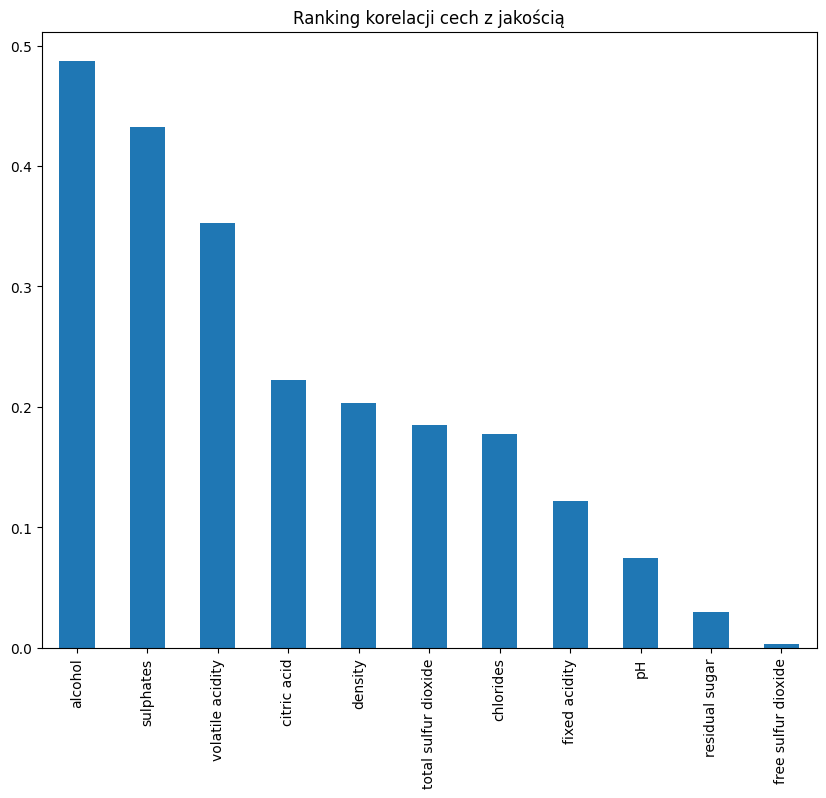

In [4]:
corr_quality = df.corr()['quality'].drop('quality').abs()
corr_quality_sort = corr_quality.sort_values(ascending=False)
corr_quality_sort.plot.bar(figsize=(10, 8))
plt.title('Ranking korelacji cech z jakością')
features_drop = corr_quality_sort.nsmallest(2).index
df_reduced = df.drop(columns=features_drop)

# wyświetlenie pozostałych cech
print("Pozostałe cechy:", df_reduced.columns)
plt.show()



wariancja [0.31285114 0.23666632 0.11634236 0.09516628 0.08108429 0.07084644
 0.05530114]


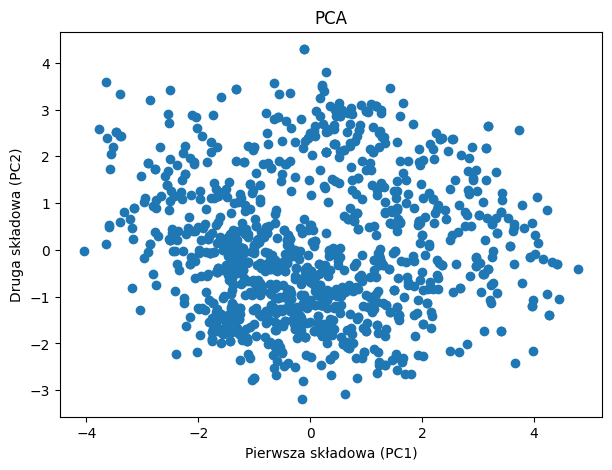

In [5]:

features = df_reduced.drop(columns=['quality'])
pca = PCA(n_components=0.95)  # zachowanie 95% wariancji
X_pca = pca.fit_transform(features)

plt.figure(figsize=(7, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel('Pierwsza składowa (PC1)')
plt.ylabel('Druga składowa (PC2)')
plt.title('PCA')
print("wariancja", pca.explained_variance_ratio_)
plt.show()

# **Model Podstawowy**

In [6]:
df_reduced.head()

,fixed acidity,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.515118,1.080434,-1.362467,-0.172699,-0.288189,0.785396,1.416900,-0.604394,-0.995609,-0.861004
1,-0.238154,2.177185,-1.362467,1.426144,1.050509,0.143571,-0.965960,0.468811,-0.573214,-0.861004
2,-0.238154,1.446017,-1.140096,0.990096,0.523143,0.271936,-0.504761,0.200510,-0.573214,-0.861004
3,2.116037,-1.478651,1.750726,-0.245374,0.766543,0.913761,-1.273425,-0.425526,-0.573214,0.521522
4,-0.515118,1.080434,-1.362467,-0.172699,-0.288189,0.785396,1.416900,-0.604394,-0.995609,-0.861004


In [7]:
X_df = df_reduced[['fixed acidity','volatile acidity','citric acid', 'chlorides', 'total sulfur dioxide', 'density','pH', 'sulphates', 'alcohol']]
Y_df = df_reduced['quality']

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X_df, Y_df, random_state=50)
# X_train = train_df[['fixed acidity','volatile acidity','citric acid', 'chlorides', 'total sulfur dioxide', 'density','pH', 'sulphates', 'alcohol']]
# Y_train = train_df['quality']
# X_test = test_df[['fixed acidity','volatile acidity','citric acid', 'chlorides', 'total sulfur dioxide', 'density','pH', 'sulphates', 'alcohol']]
# Y_test = test_df['quality']
linReg = LinearRegression().fit(X_train, Y_train)
linReg.score(X_train,Y_train)
linReg.coef_
linReg.intercept_
y_predic = linReg.predict(X_test)
print(y_predic)


[ 0.84827295 -0.67679601  0.35624866 -0.79985218  0.95468331  1.1454046
 -0.0020631  -0.56881717 -0.85900222 -0.49139656  1.24741234  1.4456242
  0.74078713 -0.27463273 -0.49139656 -0.2553764  -0.81633719  0.4435774
  0.31243855 -0.84903707 -0.45833803  0.01939262 -0.59642907  0.28607726
  0.33139874 -0.58399053  0.8904415   0.71100384 -0.89408688 -0.74601046
 -0.63545493  0.09711389 -0.22606613 -0.34127459 -0.15298583 -0.12285644
 -0.4661638  -1.08981004  0.14588755  0.31656502 -0.14913199 -0.33208989
  0.5786487  -0.70092053 -0.63364527 -0.8710068   0.54800189 -0.60100038
 -0.75673228 -0.85099171 -0.64957706  0.92267656 -0.2438397  -0.88874145
  0.34132476  0.61808772  0.36519625  0.73989462 -0.76338102  0.1274219
  0.96171924 -0.34984067 -0.3886956  -0.11556136 -0.4314147   0.69591694
  0.26493353 -0.10355873 -0.71487919 -0.23862342  0.75583041 -1.04478088
 -0.20425337  0.16206792 -0.92007744 -0.83344925 -0.35133502  0.04860189
  0.95822042  0.74848378  0.02899784  0.71100384  0.067

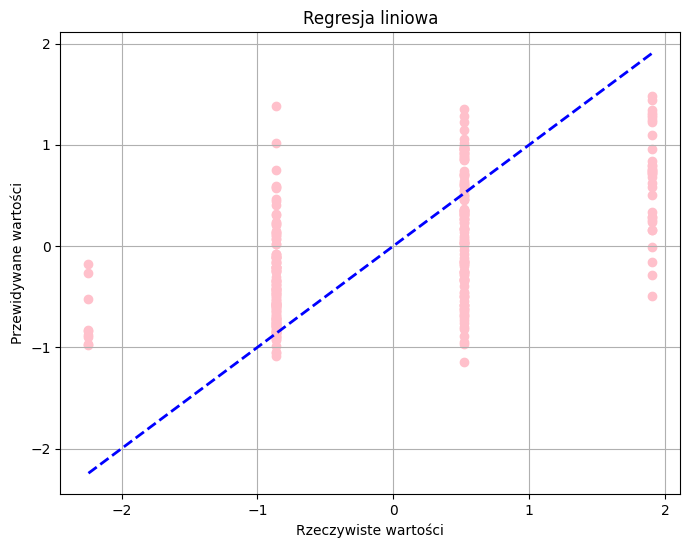

In [9]:
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, y_predic, color='pink')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='blue', linestyle='--', linewidth=2)
plt.xlabel('Rzeczywiste wartości')
plt.ylabel('Przewidywane wartości')
plt.title('Regresja liniowa')
plt.grid(True)
plt.show()

In [10]:
y_true = Y_test
print ("regresja liniowa sredni błąd bezwględny;",  mean_absolute_error(y_true,y_predic))


regresja liniowa sredni błąd bezwględny; 0.664177926553246


In [11]:
y_true = Y_test
print("regresja liniowa mediana róznic miedzy wartosciami prognozowanymi a rzeczywistymi",median_absolute_error(y_true,y_predic))

regresja liniowa mediana róznic miedzy wartosciami prognozowanymi a rzeczywistymi 0.5289141641233505


In [12]:
y_true = Y_test
print("regresja liniowa r2", r2_score(y_true,y_predic))

regresja liniowa r2 0.3262346082983817


Dzięki r2 mozemy zobaczyć iż regresja liniowa nie jest najlepszym wyborem w tym przypadku gdyż dopasowanie wynosi tylko około 33%

#**Cross Validation regresja liniowa**


In [13]:
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=45)
lin = LinearRegression()
cv_scores_lin = cross_val_score(lin, X_df , Y_df, cv=rkf, scoring='neg_mean_absolute_error')
print(cv_scores_lin)

[-0.61963169 -0.73988413 -0.61777395 -0.63637547 -0.60049163 -0.63092805
 -0.60822766 -0.64771021 -0.71191552 -0.61839417 -0.65114261 -0.67194512
 -0.62011687 -0.61256977 -0.66747375]


#**Huber Regressor**

In [14]:
huber = HuberRegressor().fit(X_train,Y_train)
huber.score(X_train,Y_train)
huber.coef_
huber.intercept_
y_predic_huber = huber.predict(X_test)
print (y_predic_huber)

[ 0.84412616 -0.73901177  0.31288074 -0.77193397  0.94559666  1.25510046
 -0.05404253 -0.60592954 -0.88491736 -0.53112038  1.30423376  1.49805336
  0.76052427 -0.28761771 -0.53112038 -0.27420817 -0.8642652   0.38902794
  0.30096097 -0.88754492 -0.49570796  0.02399711 -0.63464813  0.27852127
  0.3029121  -0.66693017  0.89833721  0.79415435 -0.91631617 -0.78145994
 -0.67423668  0.05520756 -0.26313507 -0.38773139 -0.1806135  -0.13859112
 -0.50945636 -1.14074045  0.17672099  0.37367003 -0.15424968 -0.31290753
  0.62447952 -0.7181125  -0.66767147 -0.93831472  0.57301705 -0.61350492
 -0.8184145  -0.89876565 -0.70161081  0.97552581 -0.27997    -0.92961618
  0.40014656  0.66726835  0.37878408  0.8228348  -0.80360489  0.16850781
  0.98812742 -0.38783401 -0.43918627 -0.15274043 -0.4601474   0.78699984
  0.3401031  -0.15951505 -0.75322637 -0.22158457  0.84241167 -1.0955255
 -0.23340553  0.25558085 -0.9421712  -0.84949492 -0.3946423   0.04681719
  0.9971989   0.85443045  0.03841064  0.79415435  0.

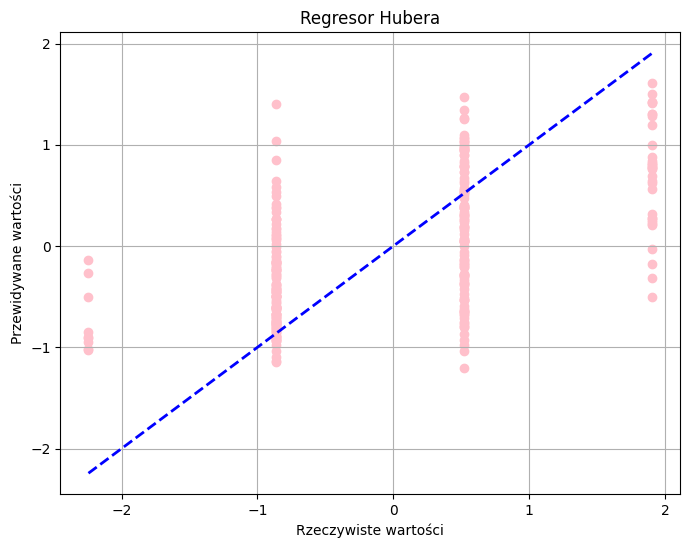

In [15]:
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, y_predic_huber, color='pink')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='blue', linestyle='--', linewidth=2)
plt.xlabel('Rzeczywiste wartości')
plt.ylabel('Przewidywane wartości')
plt.title('Regresor Hubera')
plt.grid(True)
plt.show()

In [16]:
print("regresja Hubera",mean_absolute_error(y_true,y_predic_huber))

regresja Hubera 0.6635181201204754


In [17]:
print("regresja Hubera",median_absolute_error(y_true,y_predic_huber))

regresja Hubera 0.5253091396801387


In [18]:
print("regresja Hubera r2",r2_score(y_true,y_predic_huber))

regresja Hubera r2 0.32000137510068305


Dzięki r2 mozemy zobaczyć iż regresor Hubera nie jest najlepszym wyborem w tym przypadku gdyż dopasowanie wynosi około 32% czyli mniej niż regresja liniowa

#**Cross Validation Huber Regressor**

In [19]:
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=45)
hub = HuberRegressor()
cv_scores_hub = cross_val_score(hub, X_df , Y_df, cv=rkf, scoring='neg_mean_absolute_error')
print(cv_scores_lin)

[-0.61963169 -0.73988413 -0.61777395 -0.63637547 -0.60049163 -0.63092805
 -0.60822766 -0.64771021 -0.71191552 -0.61839417 -0.65114261 -0.67194512
 -0.62011687 -0.61256977 -0.66747375]


#**Regresja wielomianowa 2 i 3 stopnia**

#2 stopień

In [20]:

model = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('linear', LinearRegression())
])

model.fit(X_train, Y_train)
y_predic_poly2 = model.predict(X_test)
print(y_predic_poly2)


[ 0.77263649 -0.88290959  0.31533162 -0.58499961  0.11341988  1.32954884
 -0.4636357  -0.26745662 -0.78433393 -0.41568514  0.78725198  1.66030267
  0.7330063  -0.21755745 -0.41568514 -0.36203003 -0.79487772  0.52634698
  0.14778654 -1.01721205 -0.3700188   0.04499171 -0.41065802  0.25941123
  0.34890883 -0.77240785  0.54104289  0.82218283 -0.82268957 -0.63840811
 -0.45659582 -0.09567528 -0.25197789 -0.33897802 -0.27526369 -0.21892178
 -0.35531355 -0.66001118  0.06063271 -0.13876381 -0.31073418 -0.60573499
  0.43799692 -0.54874737 -0.8326582  -0.63816142  0.59253577 -1.14288737
 -0.41690403 -0.47426574 -0.73814129  0.2146394  -0.30030473 -0.6249845
 -0.05509915  0.72179896  0.40296517  0.3842441  -0.84211942  0.00497068
  0.91203945 -0.17945645 -0.41853333 -0.14373154 -1.03436513  0.29694731
  0.29966616 -0.30035526 -0.53814112 -0.28041715  1.02824233 -0.70407681
 -0.31990752  0.4621552  -1.12798768 -0.88436352 -0.41028516  0.11431675
  0.92952395 -0.24492372 -0.08748576  0.82218283  0.

In [21]:

print("regresja wielomianowa 2 stopnia r2: ", model.score(X_test, Y_test))

regresja wielomianowa 2 stopnia r2:  0.30302903818662275


Dzięki r2 mozemy zobaczyć iż regresja wielomianowa 2 stopnia nie jest najlepszym wyborem w tym przypadku gdyż dopasowanie wynosi tylko około 30% czyli mniej niz liniowa i Hubera

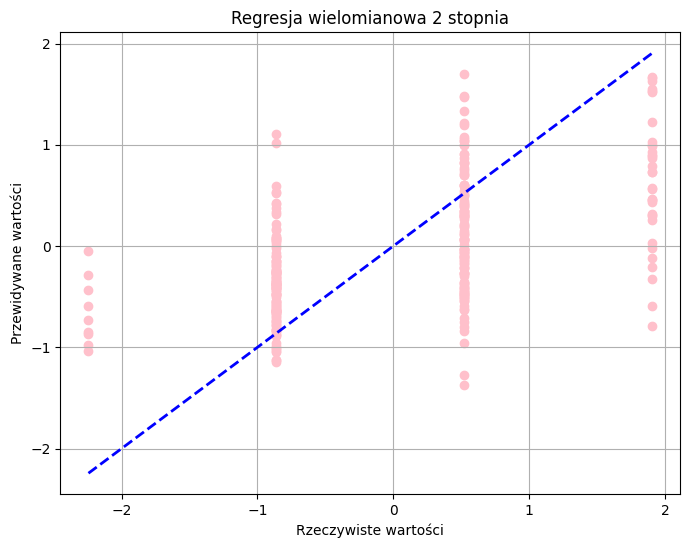

In [30]:
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, y_predic_poly2, color='pink')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='blue', linestyle='--', linewidth=2)
plt.xlabel('Rzeczywiste wartości')
plt.ylabel('Przewidywane wartości')
plt.title('Regresja wielomianowa 2 stopnia')
plt.grid(True)
plt.show()

#**Cross validation wielomianowa 2 stopnia**


In [22]:
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
lin = LinearRegression()
xpol2 = PolynomialFeatures(2)
X2 = xpol2.fit_transform(X_df)
cv_scores_poly2 = cross_val_score(lin, X2, Y_df, cv=rkf,scoring='neg_mean_absolute_error')
print(cv_scores_poly2)

[-0.59444652 -0.61271484 -0.671032   -0.6715133  -0.6800689  -0.63374785
 -0.70985201 -0.65143835 -0.61546744 -0.65896058 -0.64282792 -0.6705155
 -0.62960017 -0.68983276 -0.62689142]


# 3 stopień

In [23]:
model3 = Pipeline([
    ('poly', PolynomialFeatures(degree=3)),
    ('linear', LinearRegression())
])

model3.fit(X_train, Y_train)
y_predic_poly3 = model3.predict(X_test)
print(y_predic_poly3)

[ 1.04466110e+00  3.50487437e-01  1.01150289e-01 -4.53802777e-01
  6.15601267e-01  5.53842595e-01  2.43567636e-01 -3.71425607e-01
 -5.18776372e-01 -6.00376396e-01  4.58294135e-01  1.89507515e+00
  4.11322779e-01 -5.33324088e-02 -6.00376396e-01 -4.50581426e-01
 -5.19525289e-01  8.65321640e-01 -4.04590570e-01 -1.60821991e+00
 -1.34977403e+00  5.10660836e-01 -3.52392761e-01  4.28016192e-01
  5.03537819e-01 -8.26926033e-01  3.52836211e-01  9.93580673e-01
 -1.73518906e+00 -6.36913040e-01 -4.04057876e-01  1.20341155e+00
 -4.68873508e-01 -3.80062447e-03 -9.55479897e-01 -2.70804120e-02
  3.35963670e-02 -2.29164820e+00  1.67477227e-01  2.89966739e-01
 -5.37045783e-01 -1.20643465e-01 -1.00070212e-01 -7.74770530e-01
 -1.11846506e+00 -8.71967973e-01  2.98814719e-01 -1.38089693e+00
 -7.56368040e-01 -6.90412230e-01  1.38738636e-01  4.92634008e-01
 -4.86332451e-01 -7.09280018e-01 -9.61119882e-02 -1.59027275e+00
  2.92678243e-01 -1.80420702e-01 -6.73091435e-01 -4.69782154e-01
  1.05039100e+00 -4.47749

In [24]:
print("regresja wielomianowa 3 stopnia r2: ", model3.score(X_test, Y_test))

regresja wielomianowa 3 stopnia r2:  0.039534281614527766


Dzięki r2 mozemy zobaczyć iż regresja wielomianowa 3 stopnia jest najgorszym wyborem z przedtsawuionych gdyż dopasowanie wynosi tylko 04%

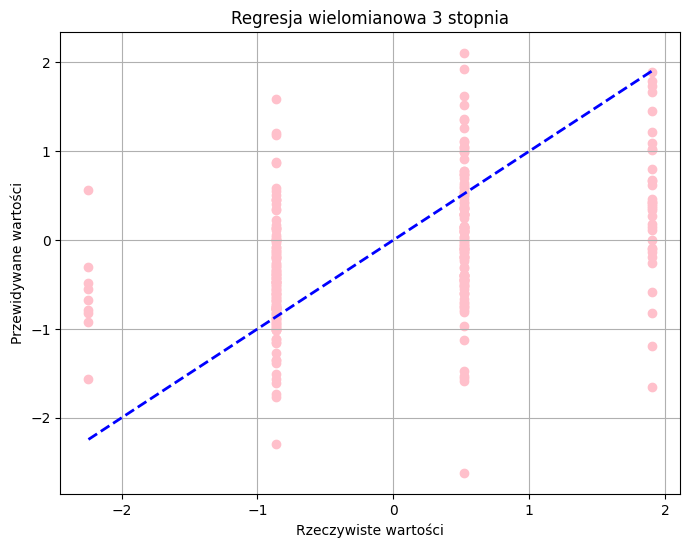

In [25]:
plt.figure(figsize=(8, 6))
plt.scatter(Y_test, y_predic_poly3, color='pink')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='blue', linestyle='--', linewidth=2)
plt.xlabel('Rzeczywiste wartości')
plt.ylabel('Przewidywane wartości')
plt.title('Regresja wielomianowa 3 stopnia')
plt.grid(True)
plt.show()

#**Cross Validation wielomianowa 3 stopnia**

In [26]:
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
lin = LinearRegression()
xpol3 = PolynomialFeatures(3)
X3 = xpol3.fit_transform(X_df)
cv_scores_poly3 = cross_val_score(lin, X3, Y_df, cv=rkf,scoring='neg_mean_absolute_error')
print(cv_scores_poly3)

[-0.72152875 -0.65851395 -0.70684083 -0.67997131 -0.75938952 -0.63031294
 -0.77604982 -0.7351995  -0.66132432 -0.66257121 -0.69004769 -0.70484158
 -0.6492409  -0.79849005 -0.68375167]


#**Cross Validation KNN**

In [28]:
knn_cv = KNeighborsRegressor(n_neighbors=4)
cv_scores_knn = cross_val_score(knn_cv, X_df, Y_df, cv=rkf)
print(cv_scores_knn)

[0.21724596 0.35800439 0.22379291 0.25453334 0.28377179 0.32077678
 0.14398923 0.26201659 0.31752943 0.32976654 0.37797338 0.25481977
 0.31627926 0.20703006 0.232972  ]


#**Box plot porówniania cross validation wszystkich modeli**

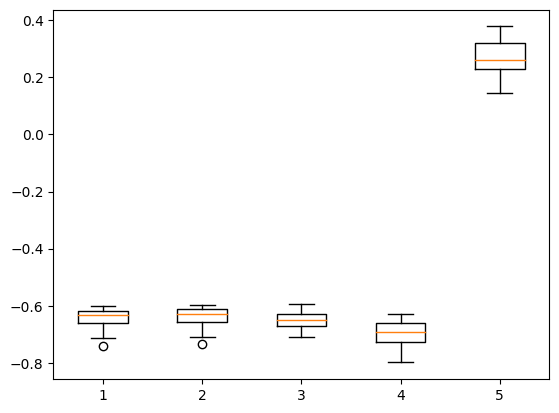

In [29]:
plt.boxplot([cv_scores_lin,cv_scores_hub, cv_scores_poly2, cv_scores_poly3, cv_scores_knn])
plt.show()